In [ ]:
from ctypes import windll
#from sympy.physics.units.definitions.unit_definitions import ms
windll.shcore.SetProcessDpiAwareness(1)
import tkinter as tk

#由你的电脑的屏幕大小来决定

def get_screen_size():
    root = tk.Tk()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width, screen_height
screen_wide,screen_high=get_screen_size()

print(screen_wide,screen_high  )


相同的DW下，16次实验，目的：探究距离的影响

1.读取数据

In [ ]:
d1,d2=3000,3000
w1,w2=60,60



import pickle
import sys

def read_data(d1,d2,w1,w2):
    '''
    通过D,和W的大小来区分和读取数据，并返回四个数据结果。
    '''
    name=sys.path[0]+'\data\\'+'D='+str(d1)+'-'+str(d2)+'_W='+str(w1)+'-'+str(w2)+".bin"

    with open(name,'rb') as file:
        move_datas=pickle.load(file)
    
    return move_datas

mouse_move=read_data(d1,d2,w1,w2)

mouse_move中，顺序是：第几条轨迹，第几个时间点，当前的位置（t,x,y）

In [ ]:
import numpy as np
for i in range(len(mouse_move)):
    print(np.shape(mouse_move[i]))
print(mouse_move[0][0])

对单条轨迹进行判断，使用冒泡算法，当前后点相同时,t相同，删除轨迹点

In [ ]:
def clean(mouse_move):
    new1=[]
    for i in range(len(mouse_move)):
        new2=[]
        t=-1
        x=-1
        y=-1
        for j in range(len(mouse_move[i])):
            
            if t==mouse_move[i][j][0] and x==mouse_move[i][j][1] and y==mouse_move[i][j][2]:
                t=mouse_move[i][j][0]
                x=mouse_move[i][j][1]
                y=mouse_move[i][j][2]
                continue
            else:
                t=mouse_move[i][j][0]
                x=mouse_move[i][j][1]
                y=mouse_move[i][j][2]
                new2.append(mouse_move[i][j])
        new1.append(new2)
    return new1

mouse_move=clean(mouse_move)

对于其中某些点进行处理，如果时间相同则，将其时间取前后时间的平均，

In [ ]:
def average(mouse_move):
    new=[]
    for i in range(len(mouse_move)):
        new1=[]
        for j in range(len(mouse_move[i])-1):
            t=mouse_move[i][j][0]
            if mouse_move[i][j][0]==mouse_move[i][j+1][0]:
                r=1
                for k in range(j+1,len(mouse_move[i])-1):
                    if mouse_move[i][j][0]==mouse_move[i][k][0]:
                        r+=1
                        #print(k)
                #print('对于',mouse_move[i][j][0],'有',r,'个连续重复值')
                
                t0=mouse_move[i][j-1][0]
                t1=mouse_move[i][j+r][0]
                m=(t1-t0)/(r+1)
                t=t0+m*2
                
            new1.append([t,mouse_move[i][j][1],mouse_move[i][j][2]])
        new.append(new1)    
    
    for i in range(len(new)):
        for j in range(len(new[i])-1):
            if new[i][j][0]==new[i][j+1][0]:
                print('存在前后相同点：',i,j)
    
    return new

mouse_move=average(mouse_move)



In [ ]:
import numpy as np
t=[]
for i in range(len(mouse_move)):
    print(np.shape(mouse_move[i]))
    print(mouse_move[i][-1][0]-mouse_move[i][0][0])
    t.append(mouse_move[i][-1][0]-mouse_move[i][0][0])

print('平均时间为',np.mean(t))

2.将轨迹数据转换为pd.DataFrame格式

In [ ]:
import pandas as pd

Track={}
for i in range(len(mouse_move)):
    Track[i]=pd.DataFrame(mouse_move[i])
    Track[i].columns=['t','x','y']
    


3.计算轨迹数据中的其他相关项（速度，角度，距离）

#进行y方向平滑处理

In [ ]:
import numpy as np




def identify(data):
    #识别异常值
    
    # 计算均值和标准差
    mean_val = np.mean(data)
    std_val = np.std(data)

    # 定义阈值（这里使用2个标准差作为阈值）
    threshold = 3 * std_val

    # 识别异常值
    outliers = [x for x in data if abs(x - mean_val) > threshold]

    # 替换异常值（这里使用均值来替换）
    for outlier in outliers:
        data[data.index(outlier)] = mean_val + (np.random.rand(1)[0])*threshold


    return data



def setValue(Track):
    '''
        计算速度和时间
    '''
    trace=[]
    for i in range(len(Track)):
        T=Track[i].t.values.tolist()
        X=Track[i].x.values.tolist()
        Y=Track[i].y.values.tolist()
        
        #将时间标准化
        t0=T[0]
        for i in range(len(T)):
            T[i]=T[i]-t0
        
        index=[0,]
        for i in range(1,len(Y)-1):
            if Y[i]==Y[i-1] and Y[i]!=Y[i+1]:
                index.append(i+1)
        index.append(len(Y)-1)
        
        s=0
        S=[0,]#点在轨迹上的位置
        for i in range(1,len(X)):
            s+=np.sqrt((X[i]-X[i-1])**2+(Y[i]-Y[i-1])**2)
            S.append(s)
        
        v_x=[0,]
        for i in range(1,len(X)):
            v_x.append((X[i]-X[i-1])/(T[i]-T[i-1]))
        v_x=identify(v_x)
            
        v_y=[0,]
        for i in range(1,len(Y)):
            v_y.append((Y[i]-Y[i-1])/(T[i]-T[i-1]))
        v_y=identify(v_y)
            
        v=[0,]
        for i in range(1,len(v_x)):
            
            v.append(np.sqrt((v_x[i])**2+(v_y[i])**2))
        v=identify(v)
        
            
        pandasDataSet=[]
        for i in range(len(X)):
            pandasDataSet.append((T[i],X[i],Y[i],S[i],v_x[i],v_y[i],v[i]))
        
        trace.append(pd.DataFrame(pandasDataSet,columns=['t','x','y','s','v_x','v_y','v']))
        
    return trace

Track=setValue(Track)
print(Track[0])


绘制双变量

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d


def plot2data(Track,x,y):
    colors = [
    ('red', '#FF0000'),
    ('lime', '#00FF00'),
    ('blue', '#0000FF'),
    ('yellow', '#FFFF00'),
    ('cyan', '#00FFFF'),
    ('magenta', '#FF00FF'),
    ('orange', '#FFA500'),
    ('darkred', '#8B0000'),
    ('darkgreen', '#006400'),
    ('darkblue', '#00008B'),
    ('darkgoldenrod', '#B8860B'),
    ('purple', '#800080'),
    ('hotpink', '#FF69B4'),
    ('teal', '#008080'),
    ('silver', '#C0C0C0'),
    ('saddlebrown', '#8B4513')
]

    sorted_colors = sorted(colors)

    plt.figure(figsize=(16, 9),dpi=300)
    print(len(Track))
    for i in range(len(Track)):
        X=np.array(Track[i][x].values.tolist())
        Y=np.array(Track[i][y].values.tolist())
        
        
        #plt.axis('equal')
        # 绘制原始数据和拟合曲线
        plt.scatter(X, Y, color=sorted_colors[i][0],s=1)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(x+'-'+y)
        #plt.legend()
        plt.grid(True)
    plt.show()

5.绘制x,y的散点图

In [ ]:
plot2data(Track,'t','v')

In [ ]:
plot2data(Track,'t','v_x')

6.绘制t,s的散点图

In [ ]:
plot2data(Track,'t','s')

绘制三变量

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d


def plot3data(Track,x,y,z):
    colors = [
    ('red', '#FF0000'),
    ('black', '#00FF00'),
    ('blue', '#0000FF'),]

    sorted_colors = sorted(colors)

    #plt.figure(figsize=(16, 9),dpi=300)
    print(len(Track))
    for i in range(len(Track)):
        fig, ax1 = plt.subplots()
        fig.dpi=300
        fig.set_size_inches(16, 9)
        #plt.figure(figsize=(16, 9),dpi=300)
        X=np.array(Track[i][x].values.tolist())
        Y=np.array(Track[i][y].values.tolist())
        Z=np.array(Track[i][z].values.tolist())
        
        #plt.axis('equal')
        # 绘制原始数据和拟合曲线
        ax1.set_xlabel(x)
        ax1.set_ylabel(y, color=colors[0][0])
        ax1.scatter(X, Y, color=colors[0][0],s=1)
        ax1.tick_params(axis='y', labelcolor=colors[0][0])
        
        ax2 = ax1.twinx()  # 创建共享X轴的第二个坐标轴

        ax2.set_ylabel(z, color=colors[1][0])
        ax2.scatter(X, Z, color=colors[1][0],s=1)
        ax2.tick_params(axis='y', labelcolor=colors[1][0])
        
        
        plt.title(x+'-'+y+'-'+z)
        #plt.legend()
        plt.grid(True)
        plt.show()

将时间，轨迹，速度，放一起来看

In [ ]:
#plot3data(Track,'t','s','v')

单独绘制带有边界的,通过边界进行区分，

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

x_edge1=screen_wide/2-d1/2-w1/2
x_edge2=screen_wide/2-d1/2+w1/2
x_edge3=screen_wide/2+d1/2-w1/2
x_edge4=screen_wide/2+d1/2+w1/2

colors = [
('red', '#FF0000'),
('black', '#00FF00'),
('blue', '#0000FF'),]

sorted_colors = sorted(colors)

#plt.figure(figsize=(16, 9),dpi=300)
print(len(Track))
for i in range(len(Track)):
    fig, ax1 = plt.subplots()
    fig.dpi=300
    fig.set_size_inches(16, 9)
    #plt.figure(figsize=(16, 9),dpi=300)
    X=np.array(Track[i]['x'].values.tolist())
    Y=np.array(Track[i]['t'].values.tolist())
    Z=np.array(Track[i]['s'].values.tolist())
    
    # 绘制原始数据和拟合曲线
    ax1.set_xlabel('x')
    ax1.set_ylabel('t', color=colors[0][0])
    ax1.scatter(X, Y, color=colors[0][0],s=1)
    ax1.tick_params(axis='y', labelcolor=colors[0][0])
    
    ax2 = ax1.twinx()  # 创建共享X轴的第二个坐标轴

    ax2.set_ylabel('s', color=colors[2][0])
    ax2.scatter(X, Z, color=colors[2][0],s=1)
    
    ax2.axvline(x=x_edge1, color=colors[1][0], linestyle='--', )
    ax2.axvline(x=x_edge2, color=colors[1][0], linestyle='--', )
    ax2.axvline(x=x_edge3, color=colors[1][0], linestyle='--', )
    ax2.axvline(x=x_edge4, color=colors[1][0], linestyle='--', )
    ax2.tick_params(axis='y', labelcolor=colors[2][0])
    
    
    plt.title('t-s-x')
    #plt.legend()
    plt.grid(True)
    plt.show()

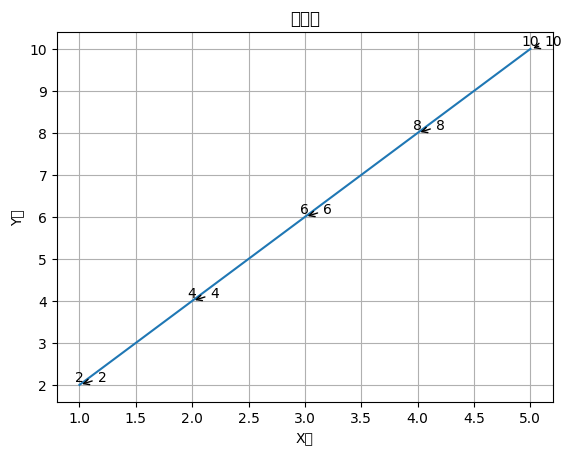

In [2]:
import matplotlib.pyplot as plt

# 示例数据
x = [1, 2, 3, 4, 5]
y = [2, 4, 6, 8, 10]

# 绘制折线图
plt.plot(x, y)
plt.xlabel('X轴')
plt.ylabel('Y轴')
plt.title('示例图')
plt.grid(True)

# 使用text()函数在指定位置显示数字
for i in range(len(x)):
    plt.text(x[i], y[i], str(y[i]), ha='center', va='bottom')

#使用annotate()函数在指定位置添加带箭头的文本框来显示数字
for i in range(len(x)):
    plt.annotate(str(y[i]), xy=(x[i], y[i]), xytext=(x[i]+0.2, y[i]),
                 arrowprops=dict(arrowstyle='->'), ha='center', va='bottom')

plt.show()
